In [1]:
import torch
import torch.nn as nn

class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()
        
        self.col1 = nn.Sequential(
            nn.Conv2d(3, 16, 9, 1, 4), nn.BatchNorm2d(16), nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, 7, 1, 3), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 16, 7, 1, 3), nn.BatchNorm2d(16), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 8, 7, 1, 3), nn.BatchNorm2d(8), nn.ReLU(inplace=True),
        )

        self.col2 = nn.Sequential(
            nn.Conv2d(3, 20, 7, 1, 3), nn.BatchNorm2d(20), nn.ReLU(inplace=True),

            nn.Conv2d(20, 40, 5, 1, 2), nn.BatchNorm2d(40), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(40, 20, 5, 1, 2), nn.BatchNorm2d(20), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(20, 10, 5, 1, 2), nn.BatchNorm2d(10), nn.ReLU(inplace=True),
        )

        self.col3 = nn.Sequential(
            nn.Conv2d(3, 24, 5, 1, 2), nn.BatchNorm2d(24), nn.ReLU(inplace=True),

            nn.Conv2d(24, 48, 3, 1, 1), nn.BatchNorm2d(48), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(48, 24, 3, 1, 1), nn.BatchNorm2d(24), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(24, 12, 3, 1, 1), nn.BatchNorm2d(12), nn.ReLU(inplace=True),
        )

        self.merge = nn.Sequential(
            nn.Conv2d(30, 1, 1, 1, 0), nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x1 = self.col1(x)
        x2 = self.col2(x)
        x3 = self.col3(x)
        x = torch.cat((x1, x2, x3), 1)
        x = self.merge(x)
        return x


In [2]:
from torch.utils.data import DataLoader
import torch.optim as optim

from typing import *

def train(
    net: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    epochs: int,
    device: torch.device,
) -> Tuple[list[float], list[float]]:
    all_batch_loss = []
    all_valid_loss = []

    for epoch in range(epochs):
        net.train()

        batch_loss = .0
        valid_loss = .0

        for i, (images, target) in enumerate(train_loader):
            images = images.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()
        all_batch_loss.append(batch_loss / len(train_loader))

        net.eval()
        with torch.no_grad():
            for images, target in val_loader:
                images = images.to(device)
                target = target.to(device)

                outputs = net(images)
                loss = criterion(outputs, target)

                valid_loss += loss.item()
        all_valid_loss.append(valid_loss / len(val_loader))

        print(
            f"Epoch: {epoch + 1}/{epochs}  "
            f"Training Loss: {all_batch_loss[-1]:.7f}  "
            f"Validation Loss: {all_valid_loss[-1]:.7f}"
        )
    
    return all_batch_loss, all_valid_loss

In [12]:
def test(
    net: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> float:
    net.eval()
    test_loss = .0
    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            outputs = net(images)
            loss = criterion(outputs, target)

            test_loss += loss.item()
    return test_loss / len(test_loader), test_loss


In [4]:
from CityStreet import CityStreet
from torchvision import transforms
from torch.utils.data import random_split

PATH = "C:\\Users\\Viyerelu\\Downloads\\CityStreet\\"

transform = transforms.Compose([
    transforms.Resize(512),
])

target_transform = transforms.Compose([
    transforms.GaussianBlur(11, (3, 3)),
])

data_view1 = CityStreet(PATH, True, 1, target_resize_factor=1520/128, transform=transform, target_transform=target_transform)
data_view2 = CityStreet(PATH, True, 2, target_resize_factor=1520/128, transform=transform, target_transform=target_transform)
data_view3 = CityStreet(PATH, True, 3, target_resize_factor=1520/128, transform=transform, target_transform=target_transform)

data_concat = torch.utils.data.ConcatDataset([data_view1, data_view2, data_view3])

test_view1 = CityStreet(PATH, False, 1, target_resize_factor=1520/128, transform=transform, target_transform=target_transform)
test_view2 = CityStreet(PATH, False, 2, target_resize_factor=1520/128, transform=transform, target_transform=target_transform)
test_view3 = CityStreet(PATH, False, 3, target_resize_factor=1520/128, transform=transform, target_transform=target_transform)

test_concat = torch.utils.data.ConcatDataset([test_view1, test_view2, test_view3])

train_size = int(0.8 * len(data_concat))
val_size = len(data_concat) - train_size
train_dataset, val_dataset = random_split(data_concat, [train_size, val_size])

_, (data_shape, target_shape) = next(enumerate(DataLoader(train_dataset, batch_size=1, shuffle=True)))
print(data_shape[0].shape, target_shape[0].shape)

torch.Size([3, 512, 910]) torch.Size([1, 128, 227])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_losses(all_batch_loss: list[float], all_valid_loss: list[float]):
    plt.plot(all_batch_loss, label='Training loss')
    plt.plot(all_valid_loss, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()


def show_image(image: torch.Tensor):
    image = image.permute(1, 2, 0)
    image = image.cpu().numpy()
    plt.figure(figsize=(13, 13))
    plt.imshow(image)
    plt.show()


def visualize_pts(dataset: CityStreet, idx: int):
    image, pts = dataset.get_original(idx)
    img_numpy = image.permute(1, 2, 0).numpy().astype(np.uint8)

    for pt in pts:
        cv2.circle(img_numpy, pt, 2, (0, 255, 0), 3)
    print(len(pts))
    plt.figure(figsize=(20, 20))
    plt.imshow(img_numpy)

In [6]:
import torchinfo

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 6

mcnn = MCNN().to(DEVICE)
optimizer = optim.Adam(mcnn.parameters(), lr=0.0001)
criterion = nn.MSELoss(reduction="sum").to(DEVICE)

print(torchinfo.summary(mcnn, input_size=(BATCH, 3, 512, 910)))

Layer (type:depth-idx)                   Output Shape              Param #
MCNN                                     [6, 1, 128, 227]          --
├─Sequential: 1-1                        [6, 8, 128, 227]          --
│    └─Conv2d: 2-1                       [6, 16, 512, 910]         3,904
│    └─BatchNorm2d: 2-2                  [6, 16, 512, 910]         32
│    └─ReLU: 2-3                         [6, 16, 512, 910]         --
│    └─Conv2d: 2-4                       [6, 32, 512, 910]         25,120
│    └─BatchNorm2d: 2-5                  [6, 32, 512, 910]         64
│    └─ReLU: 2-6                         [6, 32, 512, 910]         --
│    └─MaxPool2d: 2-7                    [6, 32, 256, 455]         --
│    └─Conv2d: 2-8                       [6, 16, 256, 455]         25,104
│    └─BatchNorm2d: 2-9                  [6, 16, 256, 455]         32
│    └─ReLU: 2-10                        [6, 16, 256, 455]         --
│    └─MaxPool2d: 2-11                   [6, 16, 128, 227]         --
│   

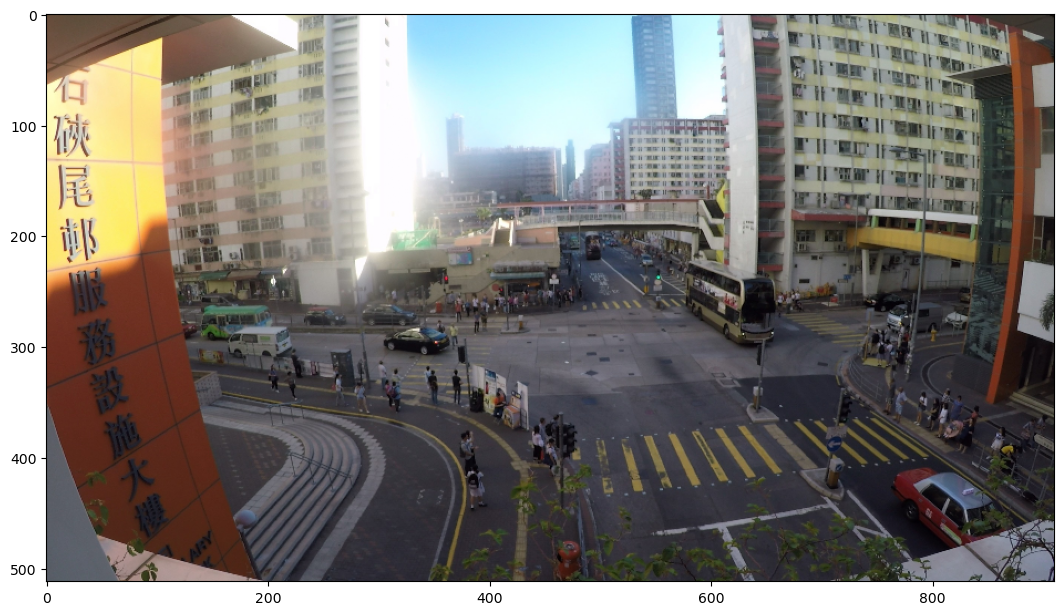

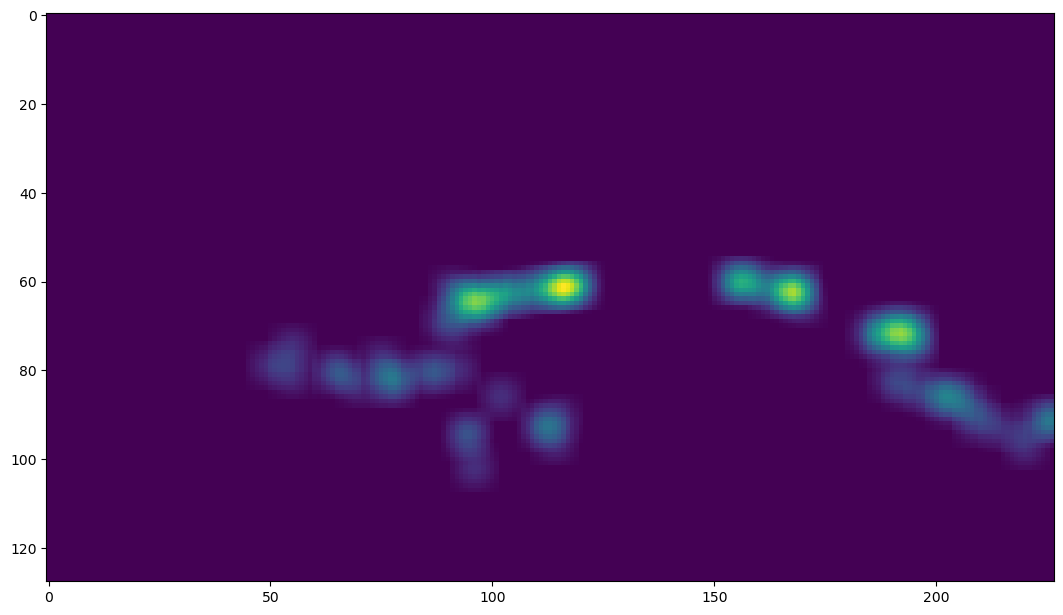

torch.Size([3, 512, 910]) torch.Size([1, 128, 227]) tensor(88.2209)


In [7]:
img_train, img_target = train_dataset[0]

img_train.squeeze(0)
img_target.squeeze(0)

show_image(img_train)
show_image(img_target)
print(img_train.shape, img_target.shape, img_target.sum())

Epoch: 1/100  Training Loss: 12402.7601766  Validation Loss: 6838.7424642
Epoch: 2/100  Training Loss: 4610.0380249  Validation Loss: 3803.4778809
Epoch: 3/100  Training Loss: 2846.8186686  Validation Loss: 2465.1284180
Epoch: 4/100  Training Loss: 2122.4175791  Validation Loss: 1915.7836955
Epoch: 5/100  Training Loss: 1687.6687571  Validation Loss: 1560.6096313
Epoch: 6/100  Training Loss: 1374.0358256  Validation Loss: 1276.6929240
Epoch: 7/100  Training Loss: 1144.5296397  Validation Loss: 1079.2719157
Epoch: 8/100  Training Loss: 967.0037043  Validation Loss: 917.3516113
Epoch: 9/100  Training Loss: 824.9652247  Validation Loss: 786.9751180
Epoch: 10/100  Training Loss: 709.3641642  Validation Loss: 681.1996277
Epoch: 11/100  Training Loss: 614.5009618  Validation Loss: 595.1271464
Epoch: 12/100  Training Loss: 536.0634649  Validation Loss: 522.6066610
Epoch: 13/100  Training Loss: 470.4743655  Validation Loss: 460.7476379
Epoch: 14/100  Training Loss: 415.1530505  Validation Loss

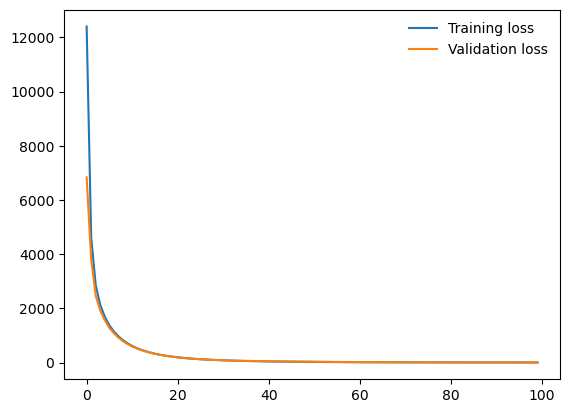

In [8]:
draw_losses(*train(
    mcnn, DataLoader(train_dataset, batch_size=BATCH), DataLoader(val_dataset, batch_size=BATCH), 
    optimizer, criterion, 100, DEVICE
))

torch.Size([1, 3, 512, 910])


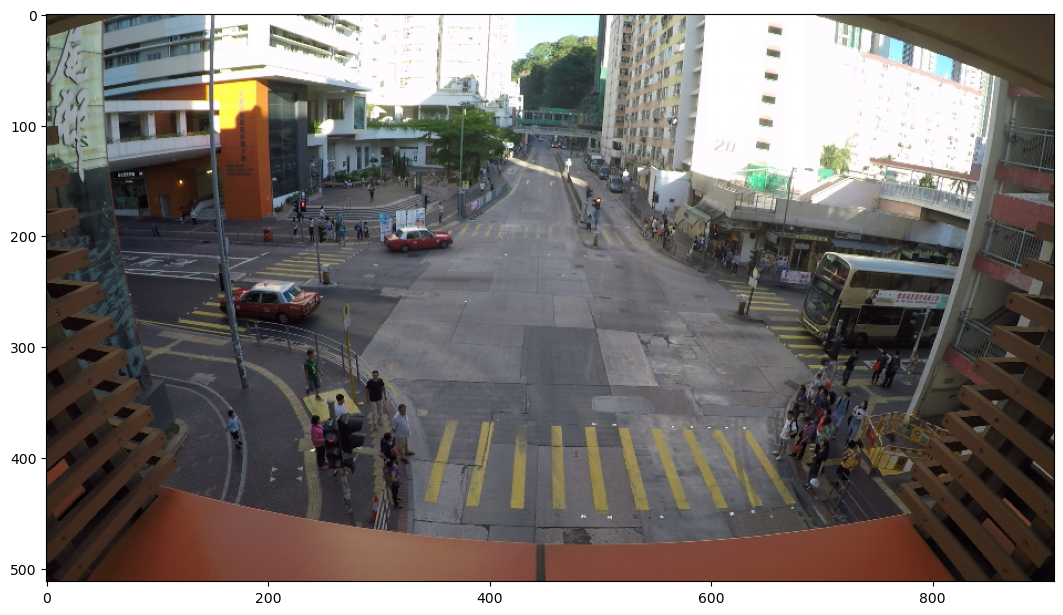

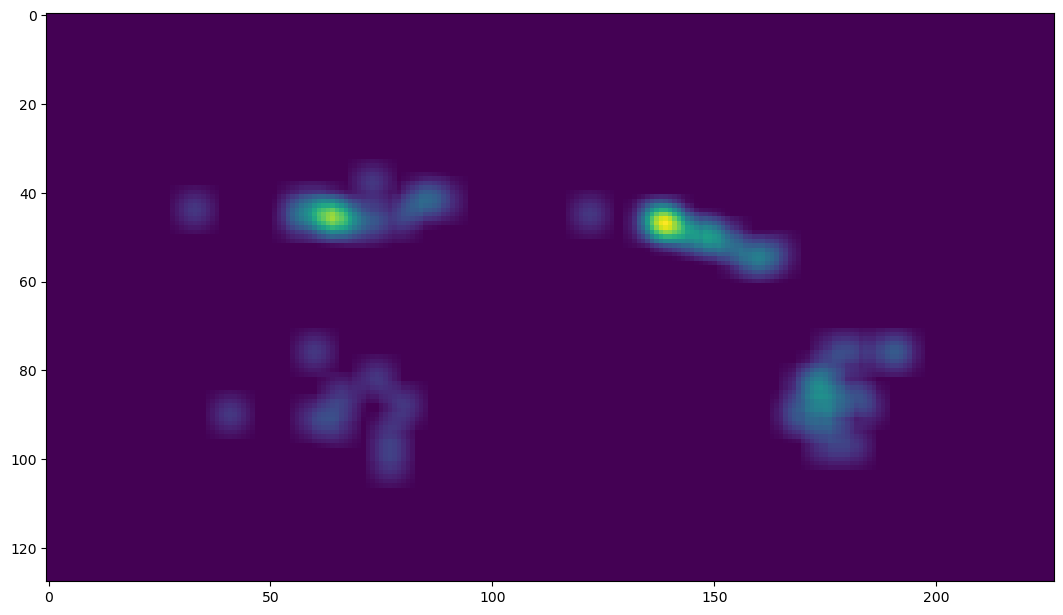

tensor(60.0000, device='cuda:0')


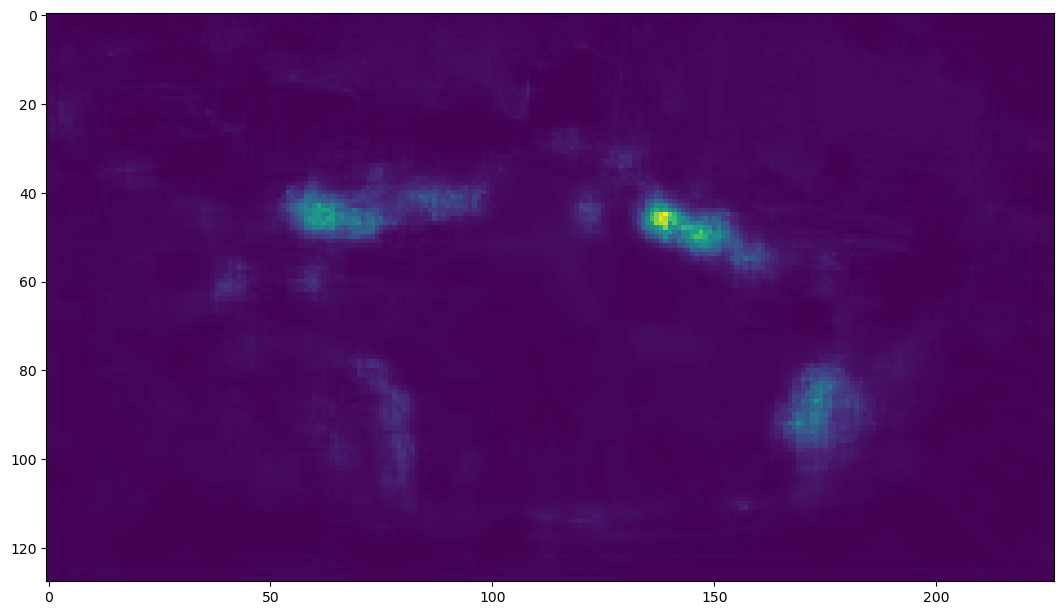

tensor(142.5769, device='cuda:0', grad_fn=<SumBackward0>)


In [9]:
image, target = test_concat[20]
image = image.unsqueeze(0)
target = target.unsqueeze(0)

print(image.shape)

image = image.to(DEVICE)
target = target.to(DEVICE)

output = mcnn(image)

show_image(image[0])
show_image(target[0])
print(target[0].sum())
show_image(output[0].cpu().detach())
print(output[0].sum())

In [13]:
test(mcnn, DataLoader(test_concat, batch_size=BATCH), criterion, DEVICE)

(7.515549182891846, 323.16861486434937)